In [17]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd


input_folder = "./TestDoors"
# output_folder = "./outputs/20220817_181813"
output_folder = "./outputs/20220817_213539"

# Load the trained model 
model = torch.load(output_folder + '/weights.pt')
print(output_folder + 'weights.pt')
# Set the model to evaluate mode
model.eval()

./outputs/20220817_213539weights.pt


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [18]:
# Read the log file using pandas into a dataframe
df = pd.read_csv(output_folder + '/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

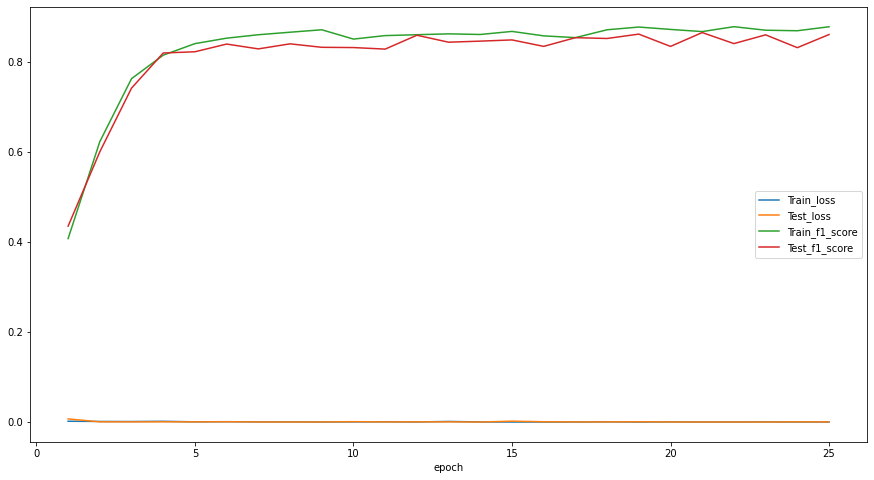

In [19]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [20]:
# print(df[['Train_auroc','Test_auroc']].max())

### Sample Prediction

In [31]:
door = 'Door' + '1504'
print(f'{input_folder}/Masks/{door}.png')

# Read  a sample image from the data-set
img = cv2.imread(f'{input_folder}/Images/{door}.png').transpose(2,0,1).reshape(1,3,640,480)

with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255) #/255 makes array of numbers from 0 to 1

./TestDoors/Masks/Door1504.png


(array([ 1450., 75712., 61053., 32275., 20302., 19072., 25945., 30382.,
        40713.,   296.]),
 array([-0.03893159, -0.01710919,  0.0047132 ,  0.02653559,  0.04835799,
         0.07018038,  0.09200277,  0.11382517,  0.13564757,  0.15746996,
         0.17929235], dtype=float32),
 <BarContainer object of 10 artists>)

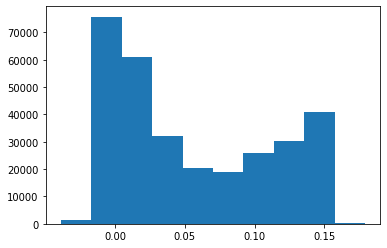

In [32]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a['out'].data.cpu().numpy().flatten())

In [33]:
import numpy as np
median = np.median(a['out'].data.cpu().numpy().flatten())
print(median)
mean = a['out'].data.cpu().numpy().flatten().mean()
print(mean)

0.034772754
0.055578943


(-0.5, 479.5, 639.5, -0.5)

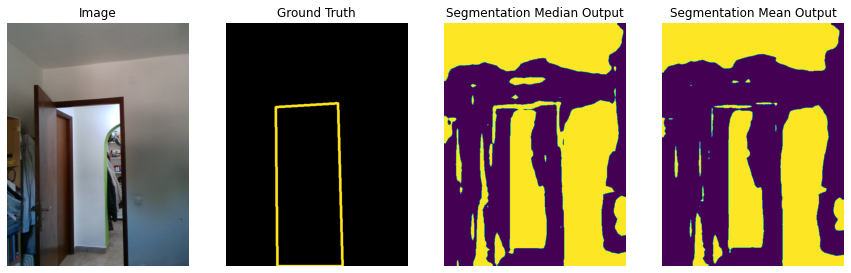

In [34]:
# Plot the input image, ground truth and the predicted output
rgb_image = cv2.cvtColor(cv2.imread(f'{input_folder}/Images/{door}.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread(f'{input_folder}/Masks/{door}.png')

plt.figure(figsize=(15,10))

plt.subplot(141)
plt.imshow(rgb_image)
plt.title('Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(143)
plt.imshow(a['out'].cpu().detach().numpy()[0][0]> median)
plt.title('Segmentation Median Output')
plt.axis('off')

plt.subplot(144)
plt.imshow(a['out'].cpu().detach().numpy()[0][0]> mean)
plt.title('Segmentation Mean Output')
plt.axis('off')
# # plt.savefig('./DoorsMediumExp/SegmentationOutput.png',bbox_inches='tight')